In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import time

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as col

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
%matplotlib notebook
plt.style.use("ggplot")

def plot_2d(x, y, labels, c, title, plot_points=2000):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(x[:plot_points], y[:plot_points], marker=".", color=c[:plot_points])
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.legend(handles=[red_label, blue_label])
    plt.title(title)

def plot_3d(x, y, z, labels, c, title, plot_points=2000):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    red_label = mpatches.Patch(color="r", label="Nontopological phase")
    blue_label = mpatches.Patch(color="b", label="Topological phase")
    
    ax.scatter(x[:plot_points], y[:plot_points], z[:plot_points], marker=".", color=c[:plot_points])
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.legend(handles=[red_label, blue_label])
    plt.title(title)

def density_plot(model, X, xmin, xmax, ymin, ymax, loc, title, labels, c, plot_points=2000, Delta_pres=True):
    xi = np.linspace(xmin, xmax, 1001)
    yi = np.linspace(ymin, ymax, 1001)

    if Delta_pres: uniform_grid = np.array([[i, j, 0] for i in xi for j in yi]) #Set to the \Delta=0 plane.
    else: uniform_grid = np.array([[i, j] for i in xi for j in yi])
    x, y = np.meshgrid(xi, yi)

    zi = model.predict(uniform_grid)
    z = zi.reshape(x.shape)

    ax = fig.add_subplot(loc)
    
    cm = col.ListedColormap(["black", "yellow"])
    ax.pcolormesh(x, y, z, cmap=cm)

    ax.scatter(X.T[0][:plot_points], X.T[1][:plot_points], marker=".", color=c[:plot_points])
    
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    plt.title(title)


<IPython.core.display.Javascript object>


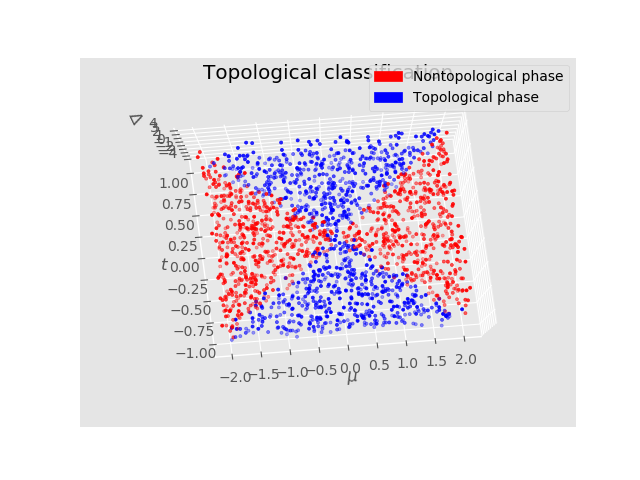

In [3]:
#Generate data with topological label.
np.random.seed(167)
length = 30000
#Note that mu can be sampled on (-1, 1) by \mu -> \mu/2 in the formula for the topological invariant M.
#Furthermore following up with the transformation (\mu, t) -> (x, y) = (\mu+t, t-\mu)/\sqrt(2) would transform the invariant condition to be dependent on only one variable (in particular making random forest much faster/accurate).
#(The validity of this rotation can be clearly seen by graphing (\mu, t), which would be one way to discover it without domain expertise.)
#Delta can also be dropped as it is not involved in the calculation of M. (Doing linear regression and checking correlation ~ 0 would be one way to justify throwing out Delta without this knowledge.)
#All these simplifications are assumed to not be known and are not made yet.
mu = np.random.uniform(-2, 2, length)
t = np.random.uniform(-1, 1, length)
Delta = np.random.uniform(-4, 4, length)

#Assign each data point with its topological invariant.
parameters = [[mu[i], t[i], Delta[i], np.sign((-2*t[i]-mu[i])*(2*t[i]-mu[i]))] for i in range(length)]
c = ["r" if parameters[i][3] == 1 else "b" for i in range(length)]

plot_points, labels = 2000, [r"$\mu$", r"$t$", r"$\Delta$"]

#Plot clearly shows nonrandom structure in (\mu, t) plane.
plot_3d(mu, t, Delta, labels, c, "Topological classification", plot_points)

<IPython.core.display.Javascript object>


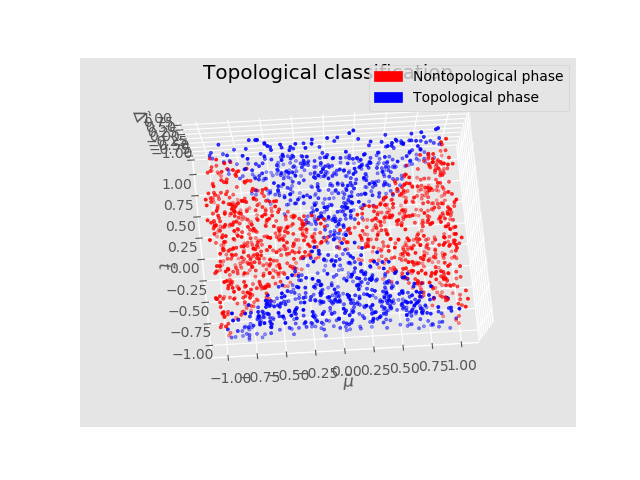

In [4]:
#Load data and separate the topological label M.
X = pd.DataFrame(parameters, columns = ["mu", "t", "Delta", "M"])
y = X.M
X.drop("M", axis=1, inplace=True)

#Transform data using the training set (to map each variable to (-1, 1)).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=59)
#It would be more rigorous to try more preprocessing methods for each classification method.
norm = preprocessing.MaxAbsScaler().fit(X_train)
X_train, X_test = norm.transform(X_train), norm.transform(X_test)

c = ["r" if list(y_train)[i] == 1 else "b" for i in range(plot_points)]
labels = [r"$\tilde{\mu}$", r"$\tilde{t}$", r"$\tilde{\Delta}$"]

plot_3d(X_train.T[0], X_train.T[1], X_train.T[2], labels, c, "Topological classification", plot_points)

KNN scores
Best parameter {'n_neighbors': 17} with score 0.9754761904761905.
Score on test set: 0.9753333333333334.
Time taken: 10.738781452178955s.

SVC scores
Best parameter {'C': 4, 'gamma': 0.8} with score 0.9926666666666667.
Score on test set: 0.9911111111111112.
Time taken: 96.61028981208801s.

Random forest scores
Out-of-bag score: 0.9878571428571429.
Score on test set: 0.9881111111111112.
Time taken: 1.6985886096954346s.



<IPython.core.display.Javascript object>


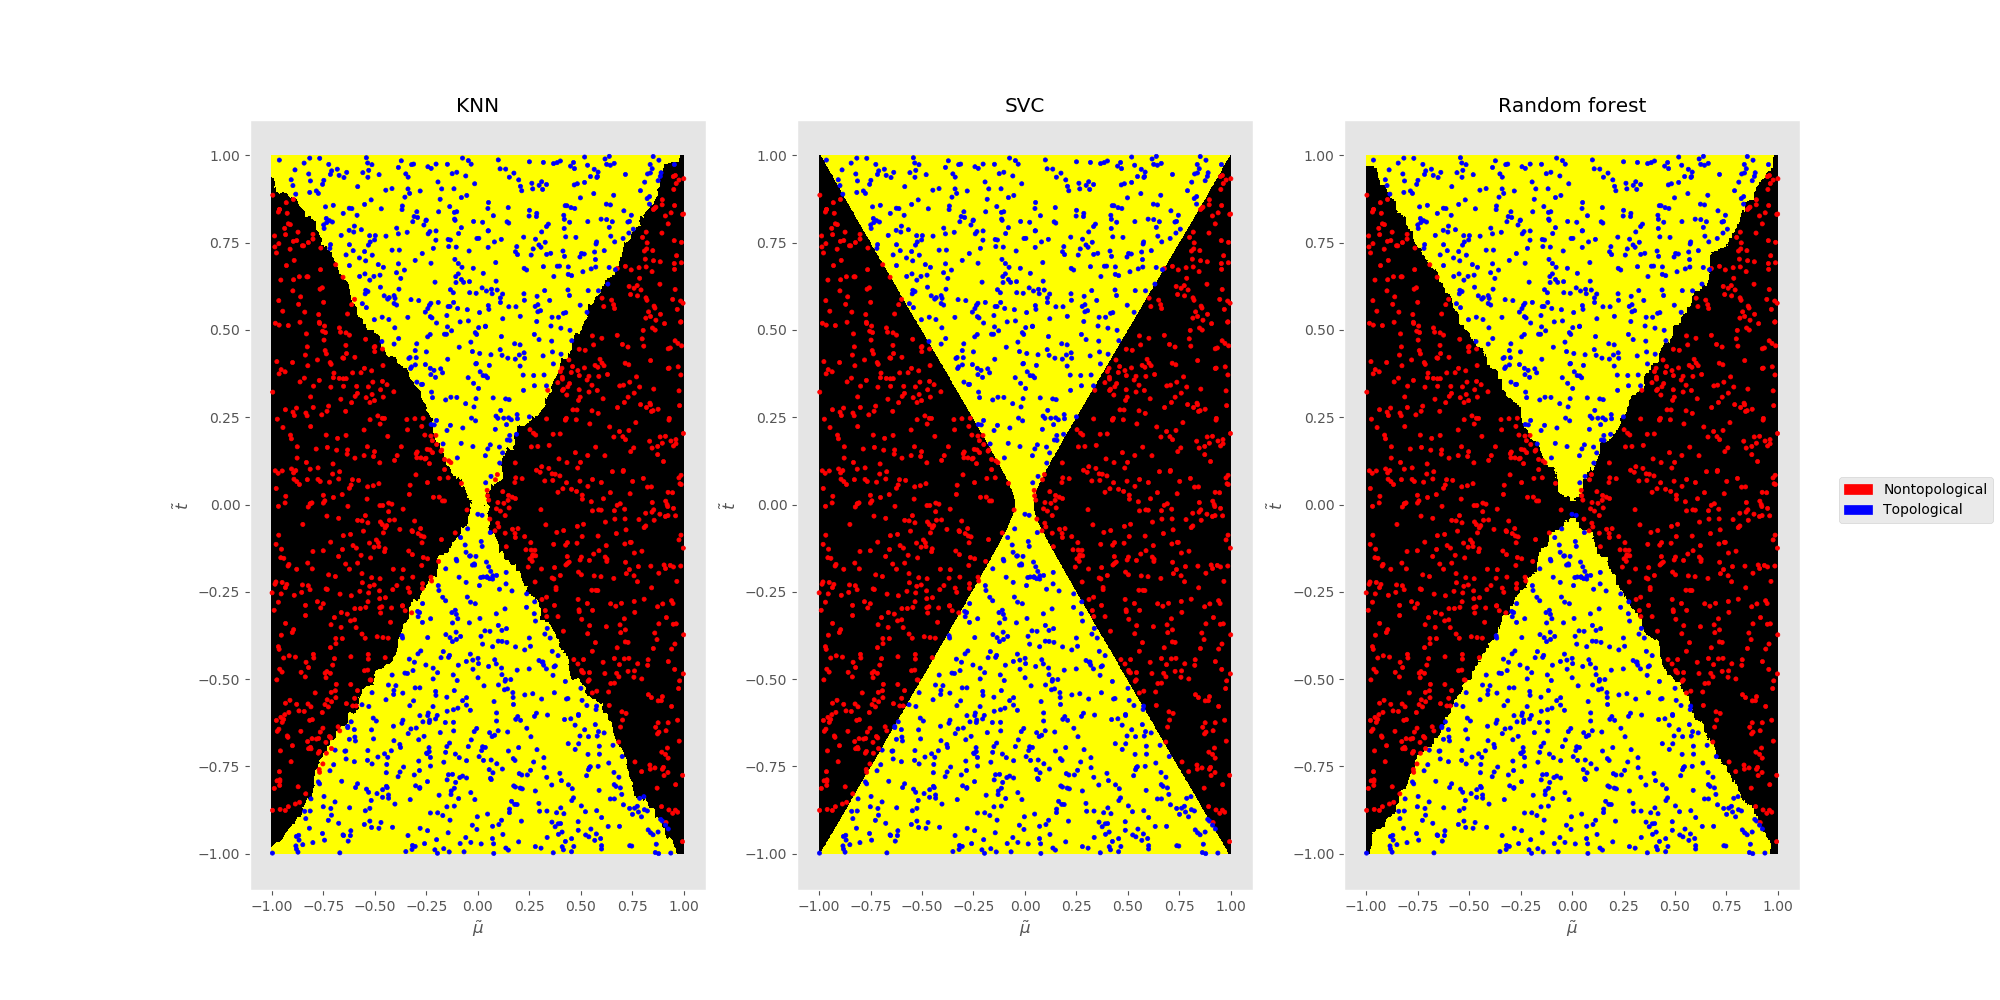

In [5]:
#KNeighbors.
knn_param = {"n_neighbors":range(1, 20)}
knn_model = KNeighborsClassifier()
knn_clf = GridSearchCV(knn_model, knn_param, cv=5)

s = time.time()
knn_fit = knn_clf.fit(X_train, y_train)
print("KNN scores")
print("Best parameter {} with score {}.".format(knn_clf.best_params_, knn_clf.cv_results_["mean_test_score"].max()))
print("Score on test set: {}.".format(knn_clf.score(X_test, y_test)))
print("Time taken: {}s.\n".format(time.time()-s))

#SVC.
svc_param = {"C":[1, 2, 3, 4, 5], "gamma":[0.8, 1, 1.2]}
svc_model = SVC()
svc_clf = GridSearchCV(svc_model, svc_param, cv=5)

s = time.time()
svc_fit = svc_clf.fit(X_train, y_train)
print("SVC scores")
print("Best parameter {} with score {}.".format(svc_clf.best_params_, svc_clf.cv_results_["mean_test_score"].max()))
print("Score on test set: {}.".format(svc_clf.score(X_test, y_test)))
print("Time taken: {}s.\n".format(time.time()-s))

#Random forest.
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True)

s = time.time()
rf_fit = rf_model.fit(X_train, y_train)
print("Random forest scores")
print("Out-of-bag score: {}.".format(rf_model.oob_score_))
print("Score on test set: {}.".format(rf_model.score(X_test, y_test)))
print("Time taken: {}s.\n".format(time.time()-s))


red_label = mpatches.Patch(color="r", label="Nontopological")
blue_label = mpatches.Patch(color="b", label="Topological")

#Density plot of classification boundaries.
fig = plt.figure(figsize=(20,10))
c = ["r" if list(y_test)[i] == 1 else "b" for i in range(plot_points)]
density_plot(knn_clf, X_test, -1, 1, -1, 1, 131, "KNN", labels, c, plot_points)
density_plot(svc_clf, X_test, -1, 1, -1, 1, 132, "SVC", labels, c, plot_points)
density_plot(rf_model, X_test, -1, 1, -1, 1, 133, "Random forest", labels, c, plot_points)
fig.legend(handles=[red_label, blue_label], loc="right")

<IPython.core.display.Javascript object>


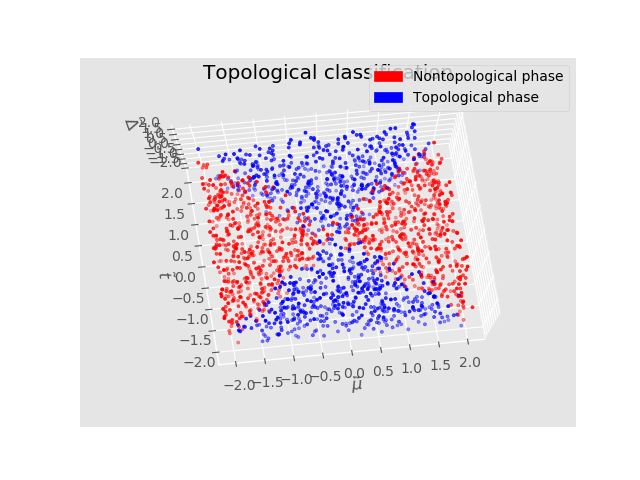

In [6]:
#Generate a new test set with expanded parameter range and check how each model does.
np.random.seed(29)
length = 100000
mu = np.random.uniform(-4, 4, length)
t = np.random.uniform(-2, 2, length)
Delta = np.random.uniform(-8, 8, length)

#Assign each data point with its topological invariant.
parameters = [[mu[i], t[i], Delta[i], np.sign((-2*t[i]-mu[i])*(2*t[i]-mu[i]))] for i in range(length)]

X = pd.DataFrame(parameters, columns = ["mu", "t", "Delta", "M"])
y = X.M
X.drop("M", axis=1, inplace=True)
X = norm.transform(X)

c = ["r" if list(y)[i] == 1 else "b" for i in range(plot_points)]

plot_3d(X.T[0], X.T[1], X.T[2], labels, c, "Topological classification", plot_points)

Scores on expanded test set below.
KNN: 0.93903.
SVC: 0.96699.
RF: 0.86428.


<IPython.core.display.Javascript object>


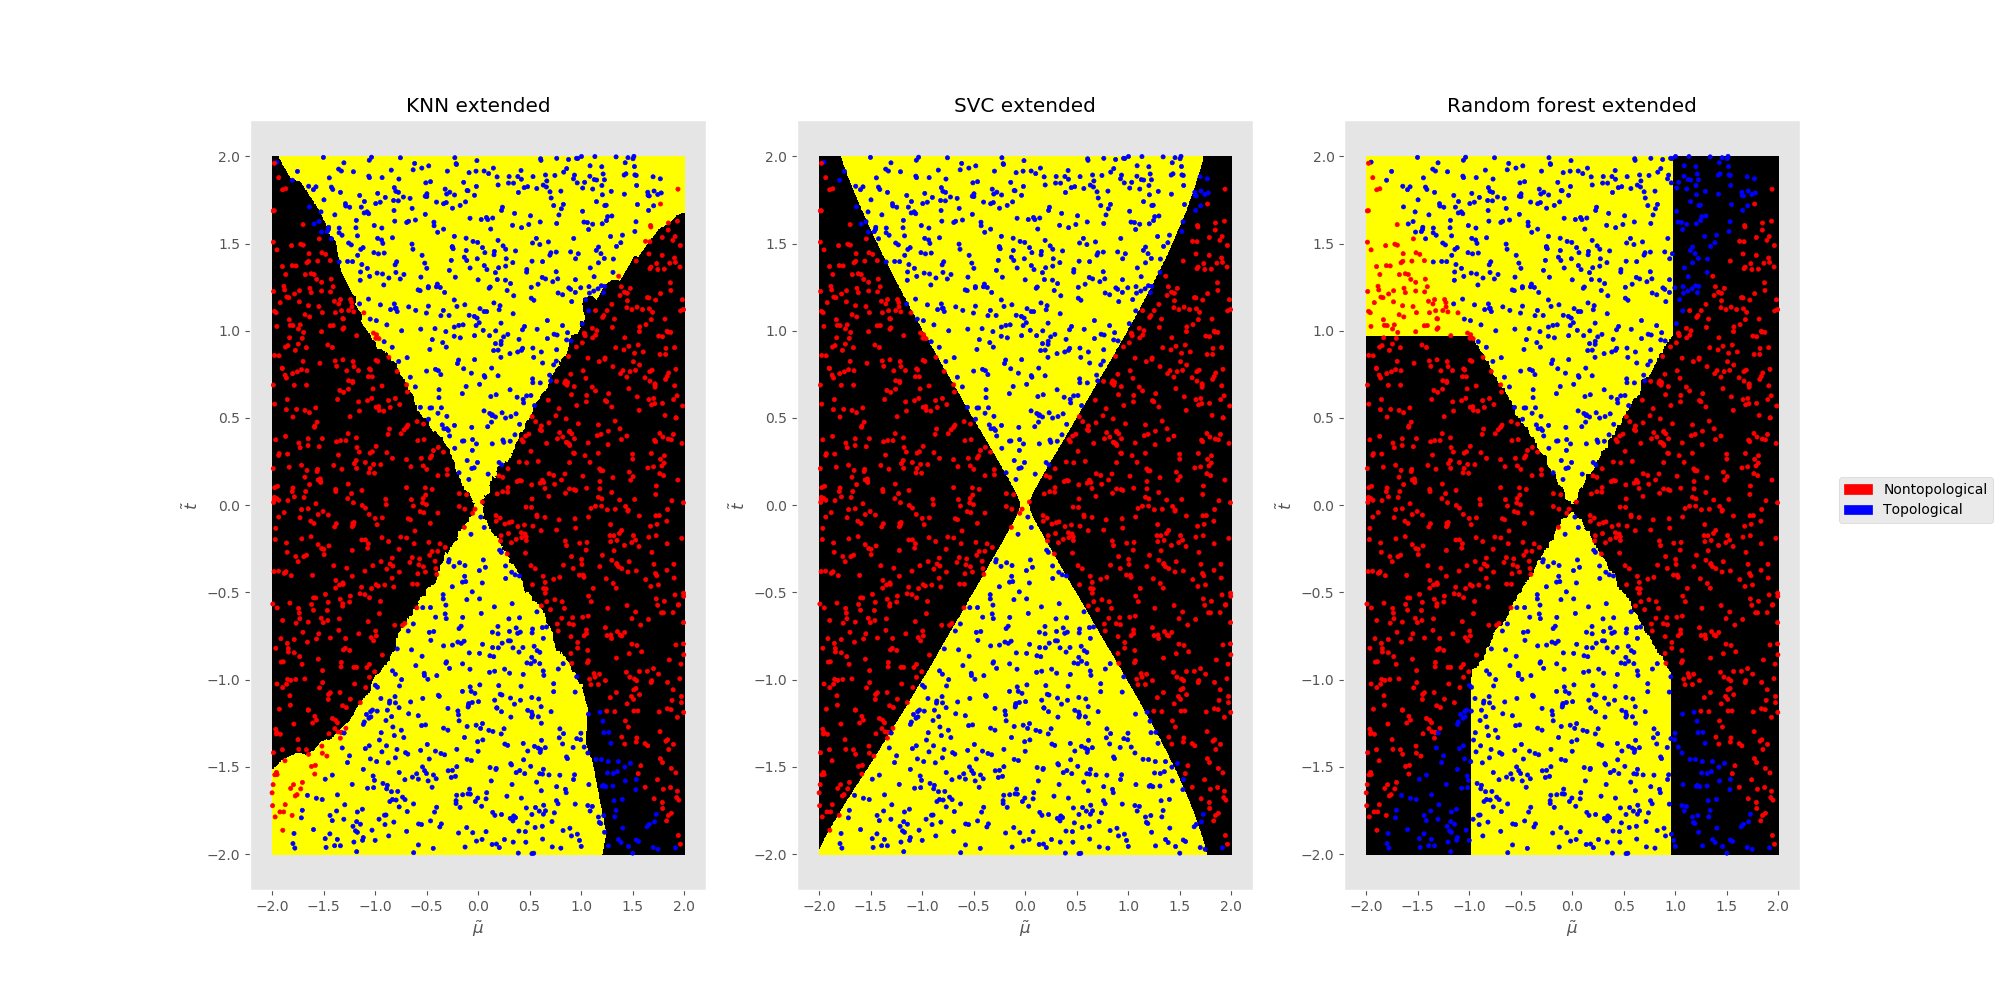

In [7]:
print("Scores on expanded test set below.")
print("KNN: {}.".format(knn_clf.score(X, y)))
print("SVC: {}.".format(svc_clf.score(X, y)))
print("RF: {}.".format(rf_model.score(X, y)))

#Check performance on the extended set (i.e. check interpolation and extrapolation.)
fig = plt.figure(figsize=(20,10))
density_plot(knn_clf, X, -2, 2, -2, 2, 131, "KNN extended", labels, c, plot_points)
density_plot(svc_clf, X, -2, 2, -2, 2, 132, "SVC extended", labels, c, plot_points)
density_plot(rf_model, X, -2, 2, -2, 2, 133, "Random forest extended", labels, c, plot_points)
fig.legend(handles=[red_label, blue_label], loc="right")


<IPython.core.display.Javascript object>


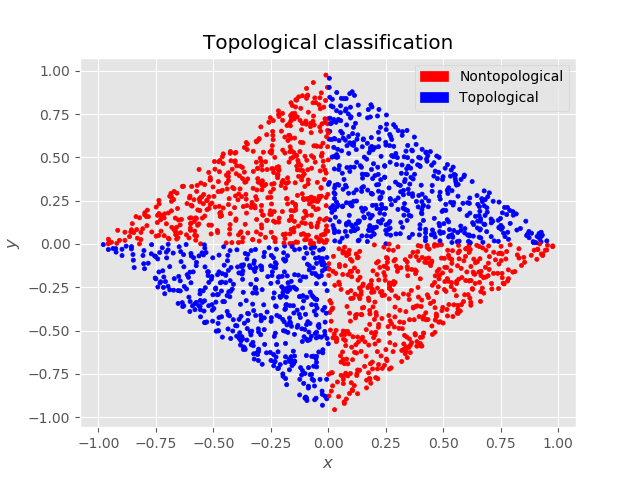

In [8]:
#Try again but drop Delta and rescale and rotate data manually.
np.random.seed(167)
length = 30000

mu = np.random.uniform(-2, 2, length)
t = np.random.uniform(-1, 1, length)

#Assign each data point with its topological invariant.
parameters = np.array([[(mu[i]/2+t[i])/2, (t[i]-mu[i]/2)/2, np.sign((-2*t[i]-mu[i])*(2*t[i]-mu[i]))] for i in range(length)])
labels = [r"$x$", r"$y$"]
c = ["r" if parameters[i][2] == 1 else "b" for i in range(length)]

plot_2d(parameters.T[0], parameters.T[1], labels, c, "Topological classification", 2000)

KNN scores
Best parameter {'n_neighbors': 11} with score 0.9924285714285714.
Score on test set: 0.9927777777777778.
Time taken: 6.549128532409668s.

SVC scores
Best parameter {'C': 5, 'gamma': 1.2} with score 0.9952380952380953.
Score on test set: 0.9973333333333333.
Time taken: 102.04976606369019s.

Random forest scores
Out-of-bag score: 0.9997142857142857.
Score on test set: 1.0.
Time taken: 1.3031525611877441s.



<IPython.core.display.Javascript object>


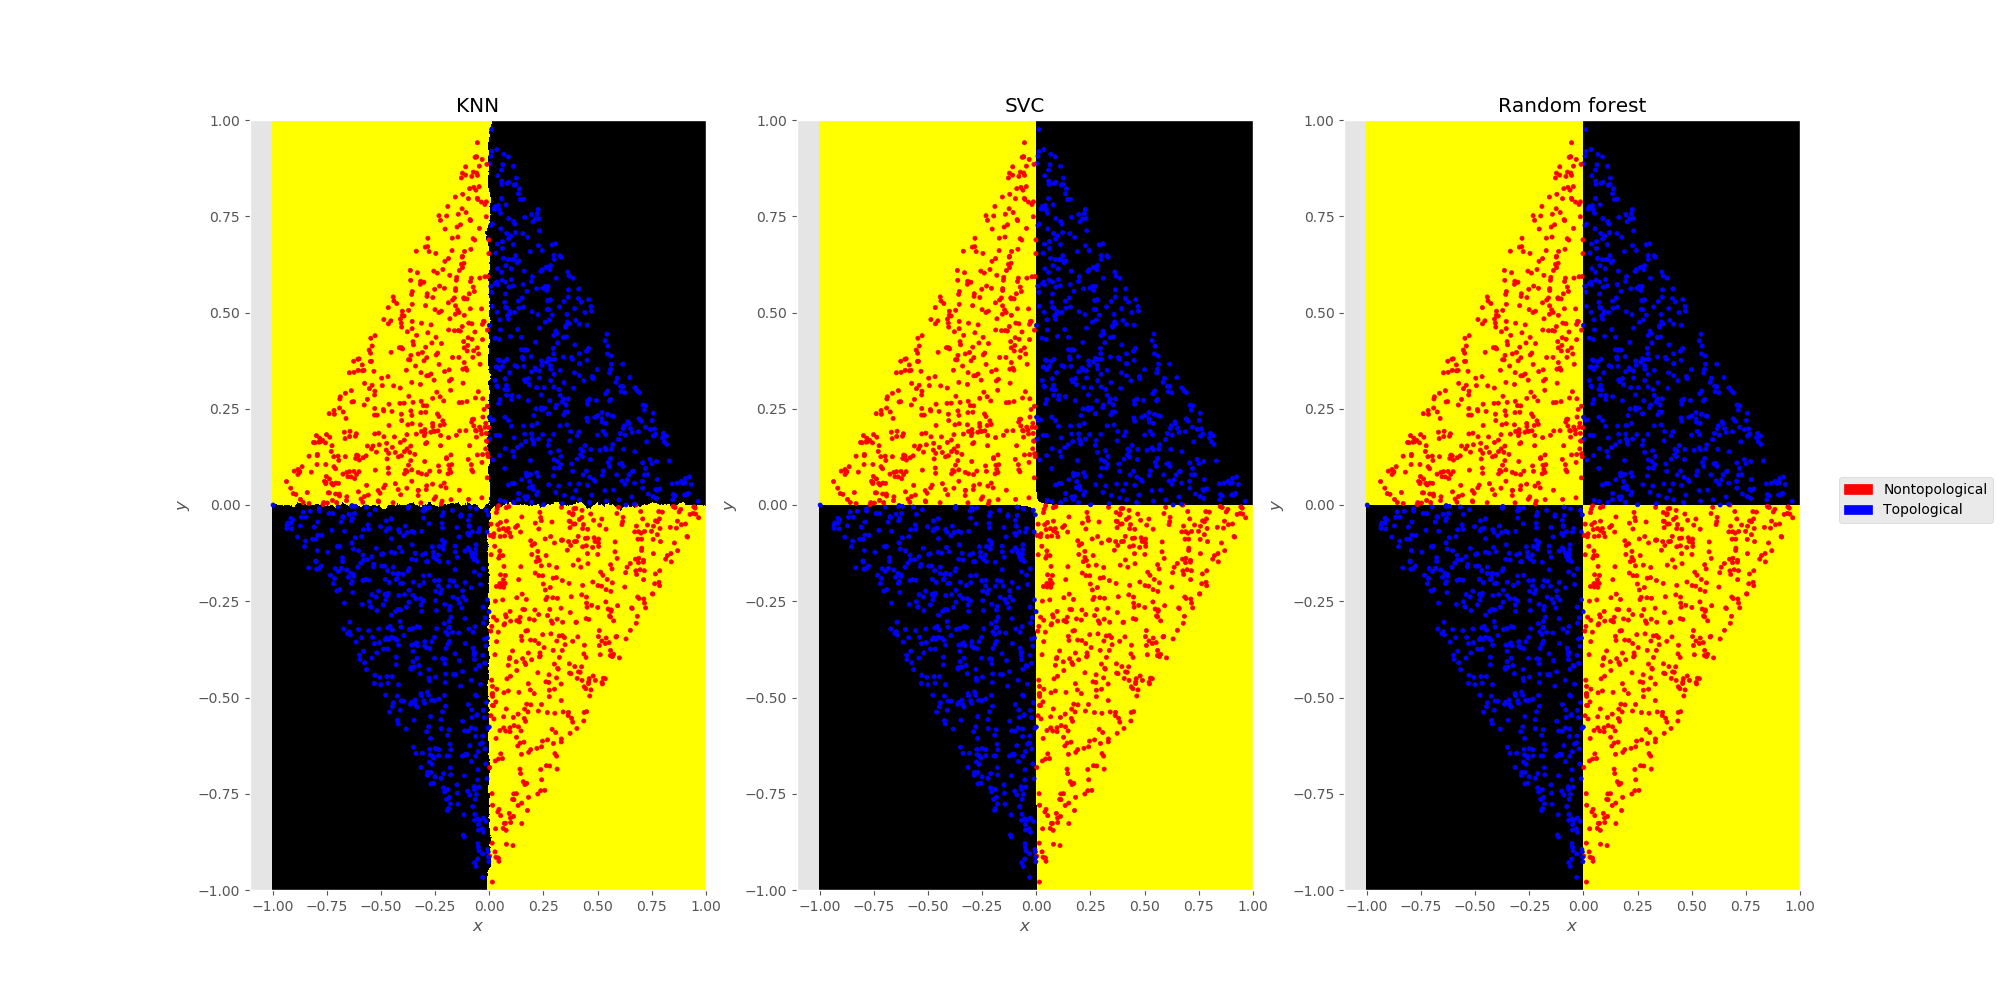

In [9]:
#Load data and separate the topological label M.
X = pd.DataFrame(parameters, columns = ["x", "y", "M"])
y = X.M
X.drop("M", axis=1, inplace=True)

#Normalise data on the training set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=59)

#KNeighbors.
knn_param = {"n_neighbors":range(1, 20)}
knn_model = KNeighborsClassifier()
knn_clf = GridSearchCV(knn_model, knn_param, cv=5)

s = time.time()
knn_fit = knn_clf.fit(X_train, y_train)
print("KNN scores")
print("Best parameter {} with score {}.".format(knn_clf.best_params_, knn_clf.cv_results_["mean_test_score"].max()))
print("Score on test set: {}.".format(knn_clf.score(X_test, y_test)))
print("Time taken: {}s.\n".format(time.time()-s))

#SVC.
svc_param = {"C":[1, 2, 3, 4, 5], "gamma":[0.8, 1, 1.2]}
svc_model = SVC()
svc_clf = GridSearchCV(svc_model, svc_param, cv=5)

s = time.time()
svc_fit = svc_clf.fit(X_train, y_train)
print("SVC scores")
print("Best parameter {} with score {}.".format(svc_clf.best_params_, svc_clf.cv_results_["mean_test_score"].max()))
print("Score on test set: {}.".format(svc_clf.score(X_test, y_test)))
print("Time taken: {}s.\n".format(time.time()-s))

#Random forest.
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True)

s = time.time()
rf_fit = rf_model.fit(X_train, y_train)
print("Random forest scores")
print("Out-of-bag score: {}.".format(rf_model.oob_score_))
print("Score on test set: {}.".format(rf_model.score(X_test, y_test)))
print("Time taken: {}s.\n".format(time.time()-s))

#Density plot of classification boundaries.
fig = plt.figure(figsize=(20,10))
c = ["r" if list(y_test)[i] == 1 else "b" for i in range(plot_points)]
density_plot(knn_clf, np.array(X_test), -1, 1, -1, 1, 131, "KNN", labels, c, plot_points, False)
density_plot(svc_clf, np.array(X_test), -1, 1, -1, 1, 132, "SVC", labels, c, plot_points, False)
density_plot(rf_model, np.array(X_test), -1, 1, -1, 1, 133, "Random forest", labels, c, plot_points, False)
fig.legend(handles=[red_label, blue_label], loc="right")

Scores on expanded test set
KNN: 0.95329.
SVC: 0.9943.
RF: 0.99998.


<IPython.core.display.Javascript object>


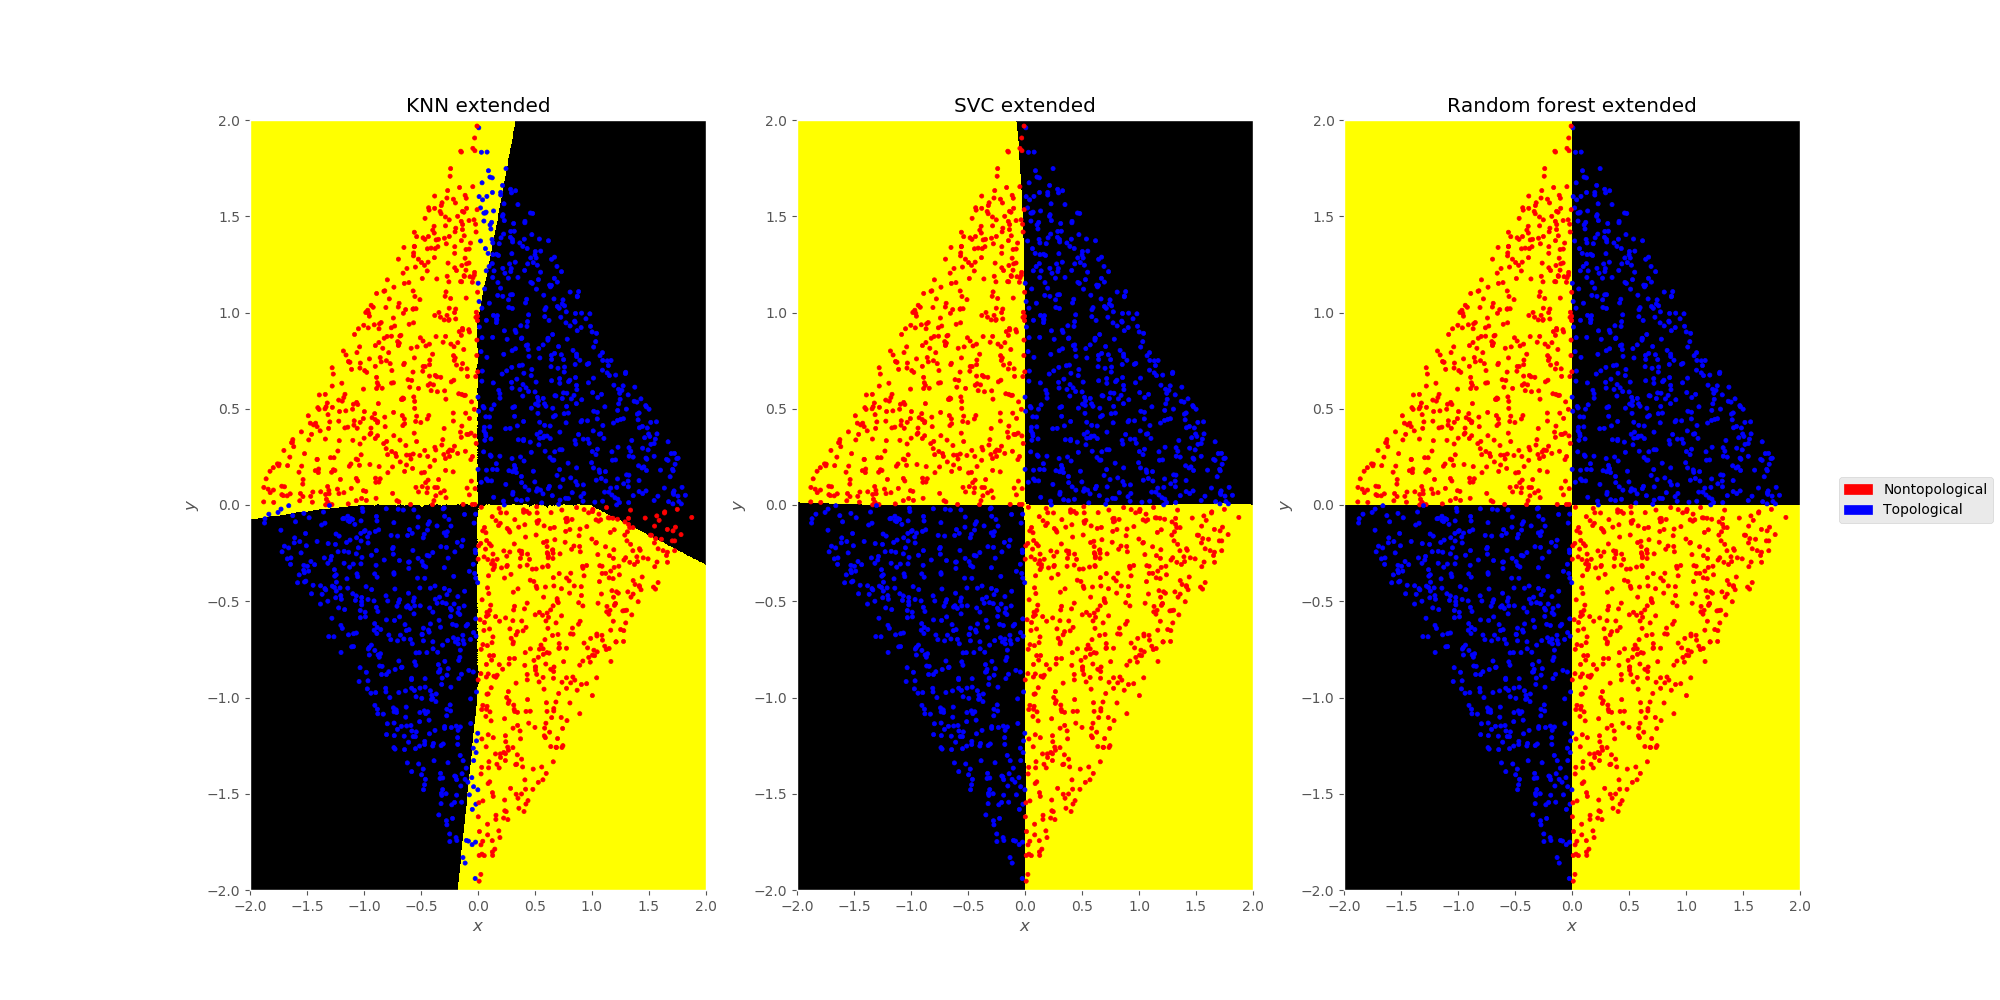

In [10]:
#Generate a new test set with expanded parameter range and check how each model does.
np.random.seed(29)
length = 100000
mu = np.random.uniform(-4, 4, length)
t = np.random.uniform(-2, 2, length)

#Assign each data point with its topological invariant.
parameters = np.array([[(mu[i]/2+t[i])/2, (t[i]-mu[i]/2)/2, np.sign((-2*t[i]-mu[i])*(2*t[i]-mu[i]))] for i in range(length)])

X = pd.DataFrame(parameters, columns = ["mu", "t", "M"])
y = X.M
X.drop("M", axis=1, inplace=True)

#Scoring each classification model on the extended set.
print("Scores on expanded test set")
print("KNN: {}.".format(knn_clf.score(X, y)))
print("SVC: {}.".format(svc_clf.score(X, y)))
print("RF: {}.".format(rf_model.score(X, y)))
       
#Density plot of classification boundaries.
fig = plt.figure(figsize=(20,10))
c = ["r" if parameters[i][2] == 1 else "b" for i in range(plot_points)]
density_plot(knn_clf, np.array(X), -2, 2, -2, 2, 131, "KNN extended", labels, c, plot_points, False)
density_plot(svc_clf, np.array(X), -2, 2, -2, 2, 132, "SVC extended", labels, c, plot_points, False)
density_plot(rf_model, np.array(X), -2, 2, -2, 2, 133, "Random forest extended", labels, c, plot_points, False)
fig.legend(handles=[red_label, blue_label], loc="right")